### The purpose of this notebook is to complete a data cleaning workflow from start to finish in order to validate the core functionality our package

#### TO DO:

- Organize code modules & tests
- Clean up/finish writing tests
- Write main script wrapper function


In [35]:
# imports

#from core import *
#from cpd_info import *
#from mol_sim_copy import *
#from pubchem_client import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pubchempy as pc
import requests
import re
from time import sleep

from bs4 import BeautifulSoup

#rdkit imports
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

#housekeeping imports
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp


## Step 1

#### Read in master dataframe



In [28]:
# read in the master_df

master_df = pd.read_csv('../../../big-datasets/master_dataframe_metacyc.csv.gz', compression='gzip') 
print(master_df.shape)
master_df = master_df.drop(columns='Fingerprint')
master_df.head()

(11467, 24)


Enzyme       product  reacts  PubChemID  \
0  1.14.14.80     CPD-10515     1.0   25201835   
1  1.14.14.80     PALMITATE     1.0     504166   
2  1.14.14.80    OLEATE-CPD     1.0    5460221   
3  1.14.14.80  STEARIC_ACID     1.0    3033836   
4  1.14.14.80     CPD-10514     1.0   19746553   

                             SMILES  n_C  n_H  n_O  n_N  n_P  ...       MW  \
0  CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O   18   35    4    0    0  ...  315.474   
1          CCCCCCCCCCCCCCCC(=O)[O-]   16   31    2    0    0  ...  255.422   
2       CCCCCCCCC=CCCCCCCCC(=O)[O-]   18   33    2    0    0  ...  281.460   
3        CCCCCCCCCCCCCCCCCC(=O)[O-]   18   35    2    0    0  ...  283.476   
4   CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-]   18   33    3    0    0  ...  297.459   

       Dist  Promiscuous  enzyme_class_1  enzyme_class_2  enzyme_class_3  \
0  0.714718          1.0               1               0               0   
1  0.714718          1.0               1               0               0   
2  0.714718          1.0               1               0               0   
3  0.714718          1.0               1               0               0   
4  0.714718          1.0               1               0               0   

   enzyme_class_4  enzyme_class_5  enzyme_class_6  enzyme_class_7  
0               0               0               0               0  
1               0               0               0               0  
2               0               0               0               0  
3               0               0               0               0  
4               0               0               0               0  

[5 rows x 23 columns]

## Step 2 
#### Get query SMILES string & pair query compound with each unique enzyme in the master DataFrame
Example: PubChem SID 3480

In [22]:
sid_to_smiles(3480)

('C1=CC=C(C=C1)C(=O)O', 243)

In [23]:
cid_to_smiles(243)

('C1=CC=C(C=C1)C(=O)O', 243)

In [25]:
def sid_to_smiles(sid):
    """Takes a PubChem SID. Returns the associated isomeric SMILES string and PubChem CID.

    Args:
        sid : The PubChem SID number.

    Returns:
        str: isomeric smiles.
        int: Pubchem CID number.

    """

    substance = pc.Substance.from_sid(sid)
    cid = substance.standardized_cid
    compound = pc.get_compounds(cid)[0]

    return compound.isomeric_smiles, cid
    
    
def cid_to_smiles(cid):

    try:
        compound = pc.get_compounds(cid)[0]
        smiles = compound.canonical_smiles
    except BaseException:
        pass
    
    return smiles, cid

In [26]:
# function to query the SMILES string and append new pairs to the master dataframe

def pair_query_compound(master_df, enzyme_col, pubchem_col, smiles_col, pubchem_cid):
    """
    pair_query_compound_with_enzymes() queries pubchem to get a SMILES string from an input pubchem_sid,
        then pairs that query compound with each unique enzyme id in the master dataframe
        
    Args:
        master_df (pandas.DataFrame): master dataframe containing enzyme ids
        enzyme_col (str): column containing enzyme id
        pubchem_col (str): column containing pubchem cid
        smiles_col (str): column containing SMILES string
        pubchem_cid (str): query PubChem cid
        
    Returns:
        pandas.DataFrame: with rows added to include query compound
    """
    master_df = master_df[[enzyme_col, pubchem_col, smiles_col]]
    new_pairs = []
    smiles, _ = cid_to_smiles(pubchem_cid)
    if len(smiles) == 0:
        raise 'query compound SMILES string could not be retrieved'
    else:
        pass
    unique_enzymes = master_df[enzyme_col].unique().tolist()
    for enzyme in unique_enzymes:
        pair = {enzyme_col:enzyme, pubchem_col:pubchem_cid, smiles_col:smiles}
        new_pairs.append(pair)
    new_paris_df = pd.DataFrame(new_pairs)
    output_df = pd.concat((master_df, new_paris_df), axis=0, sort=False)
    return output_df


In [29]:
# pair_query_compound_with_enzymes()

updated_df = pair_query_compound(master_df, 'Enzyme', 'PubChemID', 'SMILES', '243')
print(updated_df.shape)
updated_df.head()

(14807, 3)


Enzyme PubChemID                            SMILES
0  1.14.14.80  25201835  CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O
1  1.14.14.80    504166          CCCCCCCCCCCCCCCC(=O)[O-]
2  1.14.14.80   5460221       CCCCCCCCC=CCCCCCCCC(=O)[O-]
3  1.14.14.80   3033836        CCCCCCCCCCCCCCCCCC(=O)[O-]
4  1.14.14.80  19746553   CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-]

In [49]:
#updated_df.drop(columns=['Mol', 'Fingerprint'], inplace=True)
small = updated_df.iloc[:100,:]
updated_df.head(20)

Enzyme  PubChemID                                             SMILES
0   1.14.14.80   25201835                   CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O
1   1.14.14.80     504166                           CCCCCCCCCCCCCCCC(=O)[O-]
2   1.14.14.80    5460221                        CCCCCCCCC=CCCCCCCCC(=O)[O-]
3   1.14.14.80    3033836                         CCCCCCCCCCCCCCCCCC(=O)[O-]
4   1.14.14.80   19746553                    CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-]
5     2.7.7.81    7058166  C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...
6     2.7.7.81   70678926  CC(C(C1C(C(CC(O1)(C(=O)[O-])O)O)NC(=O)C)NC(=O)C)O
7    1.1.1.393   20848964  CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)...
8    1.1.1.393   20848971  CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2CCC4C3(CCC(C4)O...
9    1.1.1.393  122706120  CC(CCC(=O)[O-])C1CCC2C1(C(=O)CC3C2C(=O)CC4C3(C...
10   1.1.1.393   20848943  CC(CCC(=O)[O-])C1CCC2C1(CCC3C2C(CC4C3(CCC(C4)O...
11   1.1.1.393   90658411  CC1(C2CCC3(C(C2(CCC1O)C)C(=O)C=C4C3(CCC5(C4CC(...
12    2.6.1.51    7059387              C(C(C(=O)[O-])[NH3+])OP(=O)([O-])[O-]
13    2.6.1.51     164533                        C(CC(=O)[O-])C(=O)C(=O)[O-]
14     2.7.4.6   21604868  C1=NC2=C(N1C3C(C(C(O3)COP(=O)([O-])OP(=O)([O-]...
15     2.7.4.6   21124327  CC1=CN(C(=O)NC1=O)C2CC(C(O2)COP(=O)([O-])OP(=O...
16     2.7.4.6    7156952  C1=NC(=O)C2=C(N1)N(C=N2)C3C(C(C(O3)COP(=O)([O-...
17     2.7.4.6   46173552  C1C(C(OC1N2C=NC3=C2NC=NC3=O)COP(=O)([O-])OP(=O...
18     2.7.4.6   20056867  C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...
19     2.7.4.6   25245673  C1C(C(OC1N2C=NC3=C2NC(=NC3=O)N)COP(=O)([O-])OP...

## Step 3
#### Calculate molecular distances between products of the same enzyme
The model is based on the fact that we expect these distances to be closer for reactive enzyme-product pairs than for non-reactive enzyme-product pairs

In [46]:
def calculate_dist(input_df):
    '''Main method, takes an input dataframe and builds and returns a master
    dataframe which is the original dataframe, with three additional columns,
    an rdkit Mol column, an rdkit Fingerprint column, and a column which
    describes the average distance of a product row to all the products of the
    associated enzyme entry. Requires the KEGG enzyme entry column to be named 'entry'
        and the SMILES string column to be named 'SMILES' '''

    master_df = fingerprint_products(input_df)    #expand input df: generate mols from SMILES then generate
#fingerprints from mols, adding columns for each

    # enzyme_df_list = split_by_enzyme(input_df)    #split expanded df by rows, grouped by enzyme entry (1.1.1.110 etc),
 #into a list of dataframes
    unique_enzymes = set(master_df['Enzyme'].unique()) # create set of unique enzymes

    dist_lookup = {} # initialize master dist list

    for enzyme in unique_enzymes:    #loop through list of enzyme dataframes

        # enzyme_df['Dist'] = '' #initialize distance column
        enzyme_df = master_df[master_df['Enzyme'] == enzyme]

        metric = sim_metric(enzyme_df) #get similarity matrix dataframe

        vals = metric.values #use np array of similarity matrix

        start_at = 1 #skip autocorrelation

        dist_list =[] #initialize list

        if len(vals) == 1:
                
            dist_list.append(vals) #add distance value to list
                    
        elif len(vals) > 1:
            for i in range(len(vals)-1): #row of matrix except for last row
            
                for j in range(start_at, len(vals)): #col of matrix skipping first column
                
                    dist_list.append(vals[i][j]) #add distance value to list
            
                start_at += 1 #start at higher index to skip redundancy

        avg_dist = sum(dist_list)/len(dist_list) #compute average distance
        dist_lookup[enzyme] = avg_dist
        # for _, row in enzyme_df.iterrows():    #loop through enzyme dataframe
        #     # enzyme_df['Dist'].loc[index] = avg_dist #add averaged distance to each product row of enzyme dataframe

    master_df['dist'] = [dist_lookup[row['Enzyme']] for _, row in master_df.iterrows()]

    return master_df

def sim_i_all(input_df, index_i, row_i, metric):
    """From the input dataframe, check the passed indexes against the DataFrame,
    and construct a new dataframe which is the similarity matrix of all of the
    products contained in the dataframe."""
    for index_j, row_j in input_df.iterrows():
        if index_j < index_i: #skip redundant rows
            continue
        elif index_i == index_j: #autocorrelate rows
            metric.loc[index_i, index_j] = 1
        else:
            metric.loc[index_i, index_j] = sim_i_j(row_i, row_j) #fill matrix with calculated similarity at two position
#s at once
            metric.loc[index_j, index_i] = metric.loc[index_i, index_j]
    return

def sim_metric(input_df):
    """From an input_df, use sim_i_j and sim_i_all to build and return a
    similarity matrix dataframe."""
    metric = pd.DataFrame()
    for index_i, row_i in input_df.iterrows():
        sim_i_all(input_df, index_i, row_i, metric)
    return metric

def sim_i_j(row_i, row_j):
    """For two given rows of a dataframe, use the rdkit fingerprints to compute
    TanimotoSimilarity and return the resulting float"""
    return DataStructs.FingerprintSimilarity(row_i['Fingerprint'], row_j['Fingerprint'], metric=DataStructs.TanimotoSimilarity)

In [47]:
def fingerprint_products(input_df): #fingerprints all products in a given df
    '''DocString'''
    
    mol_list = []
    fp_list = []
    
    for index, row in input_df.iterrows():
        mol_list.append(Chem.rdmolfiles.MolFromSmiles(row['SMILES'])) #get mols from SMILES and add mols to list
        fp_list.append(FingerprintMols.FingerprintMol(Chem.rdmolfiles.MolFromSmiles(row['SMILES']))) #get fingerprints from mols and and fingerprints to list
        
    input_df.insert(0, column='Mol', value=mol_list)
    input_df.insert(1, column='Fingerprint', value= fp_list)
            
    return input_df

In [52]:
# calculate_dist() with appended dataset
# this took 1.5 min to run on 14807 lines
distance_df = calculate_dist(updated_df)
print(distance_df.shape)
distance_df.head()

(14807, 6)


Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000002729F5...   
1  <rdkit.Chem.rdchem.Mol object at 0x00000272BF4...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000272BD4...   
3  <rdkit.Chem.rdchem.Mol object at 0x000002729FD...   
4  <rdkit.Chem.rdchem.Mol object at 0x00000272BD4...   

                                         Fingerprint      Enzyme PubChemID  \
0  [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...  1.14.14.80  25201835   
1  [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80    504166   
2  [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80   5460221   
3  [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80   3033836   
4  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  1.14.14.80  19746553   

                             SMILES      dist  
0  CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O  0.412272  
1          CCCCCCCCCCCCCCCC(=O)[O-]  0.412272  
2       CCCCCCCCC=CCCCCCCCC(=O)[O-]  0.412272  
3        CCCCCCCCCCCCCCCCCC(=O)[O-]  0.412272  
4   CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-]  0.412272

In [51]:
distance_df.head(30)

Mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
1   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
2   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
3   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
4   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
5   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
6   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
7   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
8   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
9   <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
10  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
11  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
12  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
13  <rdkit.Chem.rdchem.Mol object at 0x00000272BF4...   
14  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
15  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
16  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
17  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
18  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
19  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
20  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
21  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
22  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
23  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
24  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
25  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
26  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
27  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
28  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   
29  <rdkit.Chem.rdchem.Mol object at 0x00000272BF5...   

                                          Fingerprint      Enzyme  PubChemID  \
0   [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...  1.14.14.80   25201835   
1   [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80     504166   
2   [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80    5460221   
3   [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  1.14.14.80    3033836   
4   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  1.14.14.80   19746553   
5   [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...    2.7.7.81    7058166   
6   [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...    2.7.7.81   70678926   
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...   1.1.1.393   20848964   
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...   1.1.1.393   20848971   
9   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...   1.1.1.393  122706120   
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...   1.1.1.393   20848943   
11  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...   1.1.1.393   90658411   
12  [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...    2.6.1.51    7059387   
13  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...    2.6.1.51     164533   
14  [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...     2.7.4.6   21604868   
15  [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, ...     2.7.4.6   21124327   
16  [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...     2.7.4.6    7156952   
17  [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...     2.7.4.6   46173552   
18  [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...     2.7.4.6   20056867   
19  [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...     2.7.4.6   25245673   
20  [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, ...     2.7.4.6   21122964   
21  [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...     2.7.4.6   20056717   
22  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, ...     2.7.4.6   21125569   
23  [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...   2.4.1.309    3681305   
24  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...   2.4.1.309     439637   
25  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, ...     1.7.1.5       6115   
26  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...     1.7.1.5       7472   
27  [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1

## Step 4
#### Get dummy variables to represent enzyme class
We expect that many enzyme properties could be predictive features for this model. Enzyme class should encapsulate many of these features at a high level.

In [13]:
# remove any rows that are not the query compound

reduced_df = distance_df[distance_df['PubChem'] == '3480']

In [14]:
# binarize_enzyme_class()

query_df = binarize_enzyme_class(reduced_df, 'entry')
query_df = query_df.reset_index(drop=True)
print(query_df.shape)
query_df.head()

(516, 13)


C:\Users\ellie\Documents\Data Science Classes\metamoles\code\core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]


entry PubChem               SMILES  \
0    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                                 Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2  enzyme_class_3  enzyme_class_4  \
0               1               0               0               0   
1               1               0               0               0   
2               0               1               0               0   
3               0               0               0               1   
4               0               0               1               0   

   enzyme_class_5  enzyme_class_6  enzyme_class_7  
0               0               0               0  
1               0               0               0  
2               0               0               0  
3               0               0               0  
4               0               0               0

## Step 5
#### Add in compound features with RDKit
This step uses the RDKit packages to generate descriptive features of the reaction product compounds

In [15]:
query_df = create_cpd_info(query_df)
print(query_df.shape)
query_df.head()

(516, 22)


entry PubChem               SMILES  \
0    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                                 Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2  enzyme_class_3  enzyme_class_4   ...     \
0               1               0               0               0   ...      
1               1               0               0               0   ...      
2               0               1               0               0   ...      
3               0               0               0               1   ...      
4               0               0               1               0   ...      

   enzyme_class_7  n_C  n_H  n_O  n_N  n_P  n_S  n_X  DoU       MW  
0               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
1               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
2               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
3               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
4               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 22 columns]

## Step 6
#### Re-Instantiate model

In [16]:
feature_df = master_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
features = np.array(feature_df) #shape balance array for regression
reactions = list(master_df['reacts'])
feature_train, feature_test, reaction_train, reaction_test = train_test_split(features, reactions,
                                                  test_size=0.20, random_state=42)
model_1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1', random_state=1, class_weight='balanced')
model_1.fit(feature_train, np.ravel(reaction_train))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

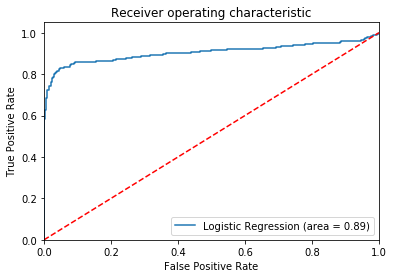

The model score is 91.93%.


In [17]:
# test the model

logit_roc_auc = roc_auc_score(reaction_test, model_1.predict(feature_test))

fpr, tpr, thresholds = roc_curve(reaction_test, model_1.predict_proba(feature_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

score = model_1.score(feature_test, reaction_test)
print('The model score is ' + str(round(score*100, 2)) + '%.')

## Step 7 
#### Use model to predict reactivity of pairs

In [11]:
# select query features

query_feat_df = query_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]

In [12]:
predictions = model_1.predict(query_feat_df) # change me to the data you want to predict based on

pred = model_1.predict_proba(query_feat_df)

prediction_values = pd.DataFrame(pred)
model_descriptive_df = pd.DataFrame()
model_descriptive_df['0']=prediction_values[0]
model_descriptive_df['1']=prediction_values[1]

In [13]:
prediction_df = pd.merge(model_descriptive_df, query_df, left_index=True, right_index=True) 
print(prediction_df.shape)
prediction_df.head()

(516, 24)


0         1       entry PubChem               SMILES  \
0  0.951846  0.048154    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  0.879409  0.120591  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2  0.948483  0.051517     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3  0.656471  0.343529    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4  0.951822  0.048178    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1a23f64ee0>   
1  <rdkit.Chem.rdchem.Mol object at 0x1a23f64d00>   
2  <rdkit.Chem.rdchem.Mol object at 0x1a23f64da0>   
3  <rdkit.Chem.rdchem.Mol object at 0x1a23f652b0>   
4  <rdkit.Chem.rdchem.Mol object at 0x1a23f65350>   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2   ...     enzyme_class_7  n_C  n_H  n_O  \
0               1               0   ...                  0  7.0  6.0  2.0   
1               1               0   ...                  0  7.0  6.0  2.0   
2               0               1   ...                  0  7.0  6.0  2.0   
3               0               0   ...                  0  7.0  6.0  2.0   
4               0               0   ...                  0  7.0  6.0  2.0   

   n_N  n_P  n_S  n_X  DoU       MW  
0  0.0  0.0  0.0  0.0  5.0  122.123  
1  0.0  0.0  0.0  0.0  5.0  122.123  
2  0.0  0.0  0.0  0.0  5.0  122.123  
3  0.0  0.0  0.0  0.0  5.0  122.123  
4  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 24 columns]

In [14]:
prediction_df = prediction_df.sort_values(by=['1'], ascending=False)
prediction_df.head()

0         1       entry PubChem               SMILES  \
359  0.201624  0.798376   1.1.1.187    3480  C1=CC=C(C=C1)C(=O)O   
365  0.249770  0.750230   1.3.1.115    3480  C1=CC=C(C=C1)C(=O)O   
319  0.250410  0.749590  1.14.14.50    3480  C1=CC=C(C=C1)C(=O)O   
174  0.251504  0.748496    4.1.1.96    3480  C1=CC=C(C=C1)C(=O)O   
254  0.265173  0.734827   4.2.1.165    3480  C1=CC=C(C=C1)C(=O)O   

                                                Mol  \
359  <rdkit.Chem.rdchem.Mol object at 0x1a23f73670>   
365  <rdkit.Chem.rdchem.Mol object at 0x1a23f73a30>   
319  <rdkit.Chem.rdchem.Mol object at 0x1a23f71cb0>   
174  <rdkit.Chem.rdchem.Mol object at 0x1a23f6be40>   
254  <rdkit.Chem.rdchem.Mol object at 0x1a23f6f350>   

                                           Fingerprint      dist  \
359  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.504968   
365  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.491018   
319  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.490846   
174  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.441723   
254  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.438121   

     enzyme_class_1  enzyme_class_2   ...     enzyme_class_7  n_C  n_H  n_O  \
359               1               0   ...                  0  7.0  6.0  2.0   
365               1               0   ...                  0  7.0  6.0  2.0   
319               1               0   ...                  0  7.0  6.0  2.0   
174               0               0   ...                  0  7.0  6.0  2.0   
254               0               0   ...                  0  7.0  6.0  2.0   

     n_N  n_P  n_S  n_X  DoU       MW  
359  0.0  0.0  0.0  0.0  5.0  122.123  
365  0.0  0.0  0.0  0.0  5.0  122.123  
319  0.0  0.0  0.0  0.0  5.0  122.123  
174  0.0  0.0  0.0  0.0  5.0  122.123  
254  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 24 columns]

In [7]:
#%%writefile query_model.py

# long query function that does all of the above, so that we can query it many times over with our validation data
def query_model(master_df, query_sid):
    """
    NOTE: Fields containing enzyme, compound PubChem sid, and SMILES string must be named 
        ['entry', 'PubChem', 'SMILES'] respectively
    """
    # get query SMILES string & pair query compound with each unique enzyme in the master DataFrame
    updated_df = pair_query_compound(master_df, 'entry', 'PubChem', 'SMILES', query_sid)
    # calculate molecular distances between products of the same enzyme
    distance_df = calculate_dist(updated_df)
    # remove any rows that are not the query compound
    reduced_df = distance_df[distance_df['PubChem'] == query_sid]
    # get dummy variables to represent enzyme class
    query_df = binarize_enzyme_class(reduced_df, 'entry')
    query_df = query_df.reset_index(drop=True)
    # add in compound features with RDKit
    cpd_query_df = create_cpd_info(query_df)
    
    # re-instantiate log reg model
    ######
    feature_df = master_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
           'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
           'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
    features = np.array(feature_df) #shape balance array for regression
    reactions = list(master_df['reacts'])
    feature_train, feature_test, reaction_train, reaction_test = train_test_split(features, reactions,
                                                      test_size=0.20, random_state=42)
    model_1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1', random_state=1, class_weight='balanced')
    model_1.fit(feature_train, np.ravel(reaction_train))
    ######

    # select query features
    query_feat_df = query_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
           'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
           'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
    # query reactive enzymes 
    predictions = model_1.predict(query_feat_df) 
    pred = model_1.predict_proba(query_feat_df)
    
    # write results to a DataFrame
    prediction_values = pd.DataFrame(pred)
    model_descriptive_df = pd.DataFrame()
#     model_descriptive_df['0']=prediction_values[0]
    model_descriptive_df['p_reacts']=prediction_values[1]
    prediction_df = pd.merge(model_descriptive_df, query_df, left_index=True, right_index=True) 
    # sort DataFrame
    prediction_df = prediction_df.sort_values(by=['p_reacts'], ascending=False)
    # reset index in output dataframe
    prediction_df = prediction_df.reset_index(drop=True)
    # add rank to dataframe
    prediction_df['rank'] = prediction_df.index + 1
    # return DataFrame
    return prediction_df

Writing query_model.py


In [16]:
# read in validation data

validation_df = pd.read_csv('../datasets/validation_data.csv')
# read in smiles string data
smiles_df = pd.read_csv('../datasets/df_cleaned_kegg_with_smiles.csv', dtype='str')
# join on validation_df to get sid numbers
valid_df = pd.merge(validation_df, smiles_df, left_on='product', right_on='KEGG', how='left')
valid_df = valid_df.drop(columns=['Unnamed: 0_x', 'product', 'Unnamed: 0_y', 'entry_y', 'CID', 'SMILES'])
valid_df = valid_df.rename(columns={'entry_x': 'true_enzyme'})
valid_df = valid_df.drop_duplicates()
valid_df = valid_df.dropna(subset=['PubChem'])
valid_df = valid_df.reset_index(drop=True)
print(valid_df.shape)
valid_df.head()

(207, 3)


true_enzyme    KEGG    PubChem
0   2.4.1.330  C19867  135626334
1    4.3.1.17  C20904  254741367
2   1.2.99.10  C21766  354339113
3  1.13.11.16  C12624     583014
4   2.1.1.324  C18033   96024253

In [17]:
# run each of these validation compounds through the query_model() function

headers = ['true_enzyme', 'KEGG', 'PubChem', 'prediction_rank', 'prediction_prob']
valid_pred_df = valid_df.reindex(columns=headers)

cpd_validation_list = valid_pred_df['PubChem'].unique().tolist()
# cpd_validation_list = ['135626334', '254741367']

for cpd in cpd_validation_list:
    try:
        prediction_df = query_model(master_df, cpd)
    except:
        pass
    handle = '../datasets/validation_data/{}.csv'.format(cpd)
    prediction_df.to_csv(handle, index=False)
    for index, row in valid_pred_df.loc[valid_pred_df.loc[:, 'PubChem'] == cpd].iterrows():
        enzyme = row['true_enzyme']
        for _, pred_row in prediction_df.loc[prediction_df.loc[:,'entry'] == enzyme].iterrows():
            valid_pred_df.loc[index, 'prediction_rank'] = pred_row['rank']
            valid_pred_df.loc[index, 'prediction_prob'] = pred_row['p_reacts']
    valid_pred_df.to_csv('validation_summary.csv', index=False)

valid_pred_df.head()

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

true_enzyme    KEGG    PubChem  prediction_rank  prediction_prob
0   2.4.1.330  C19867  135626334             12.0         0.407509
1    4.3.1.17  C20904  254741367             16.0         0.774217
2   1.2.99.10  C21766  354339113              6.0         0.700550
3  1.13.11.16  C12624     583014            383.0         0.122631
4   2.1.1.324  C18033   96024253            434.0         0.071416

In [18]:
valid_pred_df.head()

true_enzyme    KEGG    PubChem  prediction_rank  prediction_prob
0   2.4.1.330  C19867  135626334             12.0         0.407509
1    4.3.1.17  C20904  254741367             16.0         0.774217
2   1.2.99.10  C21766  354339113              6.0         0.700550
3  1.13.11.16  C12624     583014            383.0         0.122631
4   2.1.1.324  C18033   96024253            434.0         0.071416

## Out of curiosity:
#### Examine average molecular distance distributions for negative and positive data
On first glance, it appears that our hypothesis is correct in that the distributions of average molecular distances are qualitatively different between the positive and negative datasets

In [ ]:
# look at distributions of distances for positive and negative data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pos = sns.distplot(distance_df['dist'], bins=50, kde=False, ax=axes[0])
axes[0].set_title('positive data avg. mol. dist.')

neg = sns.distplot(distance_df['dist'], bins=50, kde=False, ax=axes[1])
axes[1].set_title('negative data avg. mol. dist.')

for axis in axes:
    axis.set_xlim([0.0, 1.0])